In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import os
import random

In [2]:
import tensorflow as tf
from tensorflow import keras
import keras.backend as K
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import SeparableConv2D, ZeroPadding2D, Conv2D, MaxPool2D, BatchNormalization
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from keras.optimizers import Adam


In [3]:
import matplotlib.image as mpimg
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, confusion_matrix

In [6]:
#inputdir = '../input/chest-xray-pneumonia/chest_xray'
path_train = r"C:\Users\HP\OneDrive\Documents\archive\chest_xray\train"
path_test = r"C:\Users\HP\OneDrive\Documents\archive\chest_xray\test"
path_val = r"C:\Users\HP\OneDrive\Documents\archive\chest_xray\val"
train_normal = os.path.join(r"C:\Users\HP\OneDrive\Documents\archive\chest_xray\train\NORMAL")
train_pneumonia = os.path.join(r"C:\Users\HP\OneDrive\Documents\archive\chest_xray\train\PNEUMONIA")
test_normal = os.path.join(r"C:\Users\HP\OneDrive\Documents\archive\chest_xray\test\NORMAL")
test_pneumonia = os.path.join(r"C:\Users\HP\OneDrive\Documents\archive\chest_xray\test\PNEUMONIA")
val_normal = os.path.join(r"C:\Users\HP\OneDrive\Documents\archive\chest_xray\val\NORMAL")
val_pneumonia = os.path.join(r"C:\Users\HP\OneDrive\Documents\archive\chest_xray\val\PNEUMONIA")
print("Total number of normal images in training set: ",len(os.listdir(train_normal)))
print("Total number of pneumonic images in training set: ",len(os.listdir(train_pneumonia)))
print("Total number of normal images in test set: ",len(os.listdir(test_normal)))
print("Total number of pneumonic images in test set: ",len(os.listdir(test_pneumonia)))
print("Total number of normal images in val set: ", len(os.listdir(val_normal)))
print("Total number of pnuemonic images in val set: ", len(os.listdir(val_pneumonia)))


Total number of normal images in training set:  1341
Total number of pneumonic images in training set:  3875
Total number of normal images in test set:  234
Total number of pneumonic images in test set:  390
Total number of normal images in val set:  8
Total number of pnuemonic images in val set:  8


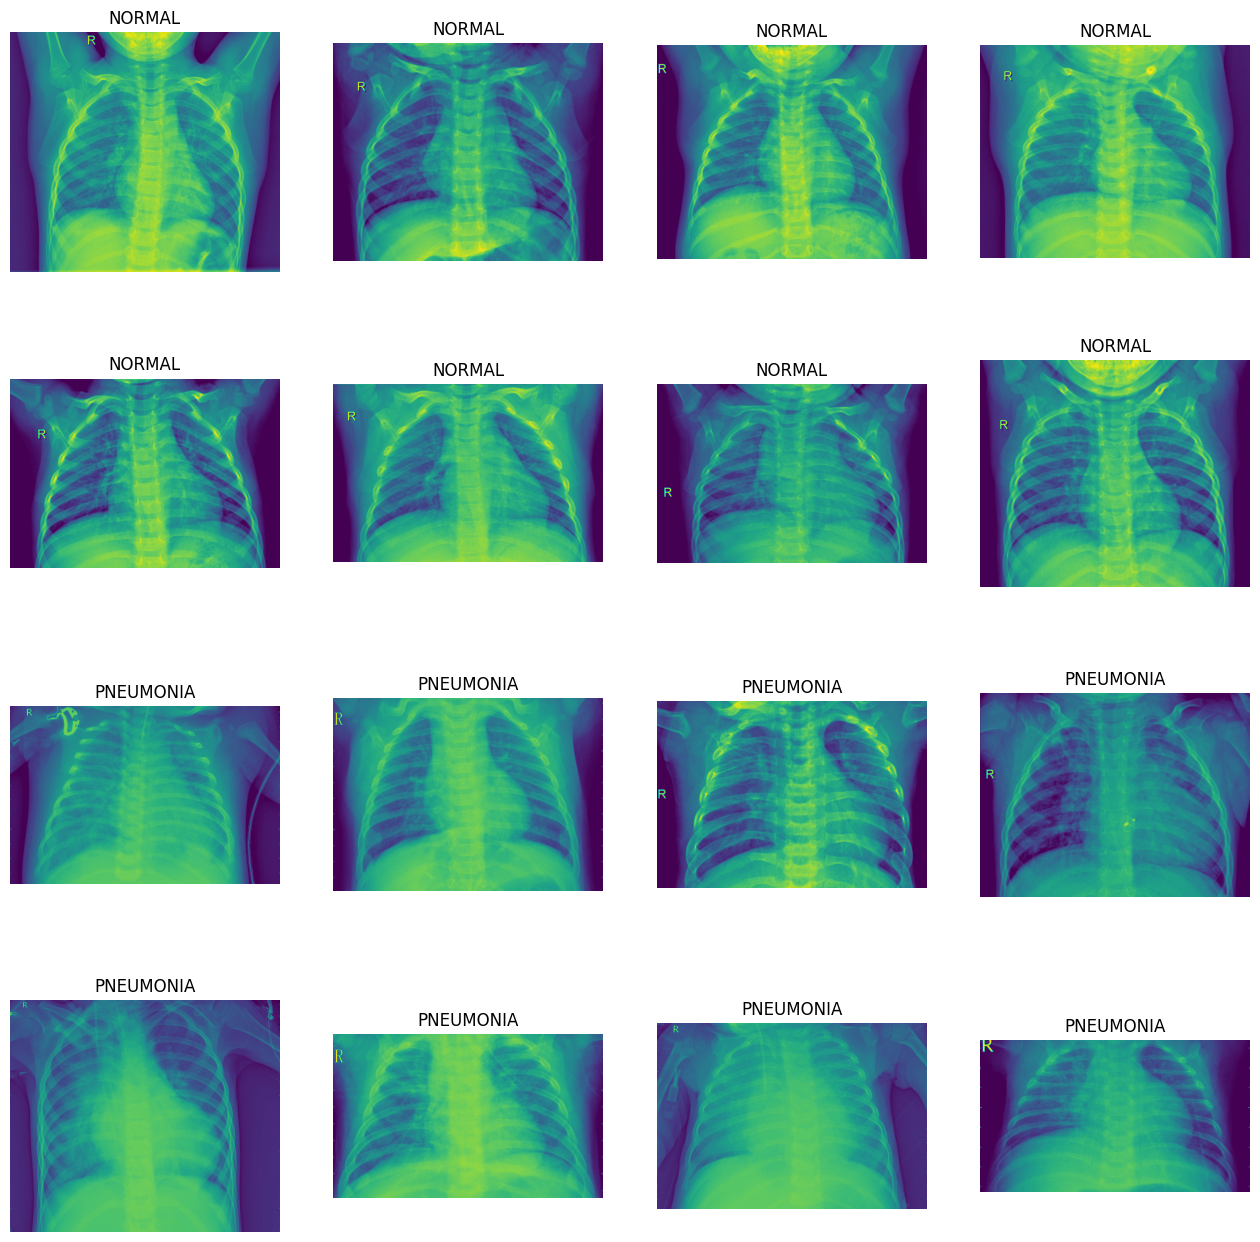

In [7]:
# Parameters for our graph; we'll output images in a 4x4 configuration
nrows = 4
ncols = 4
# Set up matplotlib fig, and size it to fit 4x4 pics
fig = plt.gcf()
fig.set_size_inches(ncols * 4, nrows * 4)
next_normal_pix = [os.path.join(train_normal, fname) for fname in os.listdir(train_normal)[0:8]]
next_pneumonia_pix = [os.path.join(train_pneumonia, fname) for fname in os.listdir(train_pneumonia)[0:8]]
for i, img_path in enumerate(next_normal_pix+next_pneumonia_pix):
    # Set up subplot; subplot indices start at 1
    sp = plt.subplot(nrows, ncols, i + 1)
    sp.axis('Off') # Don't show axes (or gridlines)
    img = mpimg.imread(img_path)
    if i<=7 :
        sp.title.set_text('NORMAL')
    else :
        sp.title.set_text('PNEUMONIA')
    plt.imshow(img)
plt.show()

In [8]:
def data_processing(img_size, batch_size):
    
    train_datagen = ImageDataGenerator(rescale = 1./255, 
                                       zoom_range = 0.3, 
                                       vertical_flip = True, 
                                       width_shift_range = 0.1, 
                                       height_shift_range = 0.1)
    
    val_datagen = ImageDataGenerator(rescale=1./255)
    
    train_set = train_datagen.flow_from_directory(
        path_train, 
        target_size=(img_size, img_size), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)
    
    val_set = val_datagen.flow_from_directory(
        path_val, 
        target_size=(img_size, img_size), 
        batch_size=batch_size, 
        class_mode='binary', 
        shuffle=True)

    test_data = []
    test_labels = []
    for cond in ['/NORMAL/', '/PNEUMONIA/']:
        for img in (os.listdir(path_test + cond)):
            img = plt.imread(path_test + cond + img)
            img = cv2.resize(img, (img_size, img_size))
            img = np.dstack([img, img, img])
            img = img.astype('float32') / 255
            if cond == '/NORMAL/':
                label = 0
            elif cond == '/PNEUMONIA/':
                label = 1
            test_data.append(img)
            test_labels.append(label)
    test_data = np.array(test_data)
    test_labels = np.array(test_labels)
    
    return train_set, val_set, test_data, test_labels

In [9]:

img_size = 150
batch_size = 32
train_set, val_set, test_data, test_labels = data_processing(img_size, batch_size)

Found 5216 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


In [10]:
model = Sequential()
model.add(Conv2D(filters = 16, kernel_size = (3, 3), input_shape = train_set.image_shape, activation = 'relu', padding = 'same'))
model.add(Conv2D(filters = 16, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(MaxPool2D(pool_size = (2, 2)))


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [11]:
model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 32, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 64, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))

In [12]:
model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 128, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))

model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(SeparableConv2D(filters = 256, kernel_size = (3, 3), activation = 'relu', padding = 'same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size = (2, 2)))
model.add(Dropout(rate = 0.2))

In [13]:
model.add(Flatten())
model.add(Dense(units = 512, activation = 'relu'))
model.add(Dropout(rate = 0.7))
model.add(Dense(units = 128, activation = 'relu'))
model.add(Dropout(rate = 0.5))
model.add(Dense(units = 64, activation = 'relu'))
model.add(Dropout(rate = 0.3))


In [14]:
model.add(Dense(units = 1, activation = 'sigmoid'))

In [15]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 150, 150, 16)        │             448 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 150, 150, 16)        │           2,320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 75, 75, 16)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d (SeparableConv2D)   │ (None, 75, 75, 32)          │             688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_1 (SeparableConv2D) │ (None, 75, 75, 32)          │           1,344 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 75, 75, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 37, 37, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_2 (SeparableConv2D) │ (None, 37, 37, 64)          │           2,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_3 (SeparableConv2D) │ (None, 37, 37, 64)          │           4,736 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 37, 37, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 18, 18, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_4 (SeparableConv2D) │ (None, 18, 18, 128)         │           8,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_5 (SeparableConv2D) │ (None, 18, 18, 128)         │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 18, 18, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 9, 9, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_6 (SeparableConv2D) │ (None, 9, 9, 256)           │          34,176 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ separable_conv2d_7 (SeparableConv2D) │ (None, 9, 9, 256)           │          68,096 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 9, 9, 256)           │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 2,314,337 (8.83 MB)

 Trainable params: 2,313,377 (8.82 MB)

 Non-trainable params: 960 (3.75 KB)

In [16]:
from keras.optimizers import Adam

model.compile(optimizer=Adam(learning_rate=0.001), loss='binary_crossentropy', metrics=['accuracy'])
 

In [17]:
from keras.callbacks import ModelCheckpoint

checkpoint = ModelCheckpoint(filepath='trained_pneumonia_model.keras', save_best_only=True, save_weights_only=False)


In [18]:
count_normal, count_pneumonia = len(os.listdir(train_normal)), len(os.listdir(train_pneumonia))

weight_0 = (1 / count_normal) * (count_normal + count_pneumonia) / 2.0
weight_1 = (1 / count_pneumonia) * (count_pneumonia + count_normal) / 2.0

class_weights = {0 : weight_0, 1 : weight_1}

In [19]:
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau

# Define the checkpoint callback
checkpoint = ModelCheckpoint(filepath='trained_pneumonia_model.keras', save_best_only=True, save_weights_only=False)

# Define the learning rate reduction callback
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=0.3, patience=2, verbose=2, mode='max')

# Then, train the model with the fit method
model_training = model.fit(
    train_set,
    steps_per_epoch=train_set.samples // batch_size,
    epochs=20,
    validation_data=val_set,
    callbacks=[checkpoint, lr_reduce],
    class_weight=class_weights
)


Epoch 1/20


C:\Users\HP\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


163/163 ━━━━━━━━━━━━━━━━━━━━ 196s 1s/step - accuracy: 0.7594 - loss: 0.5343 - val_accuracy: 0.5000 - val_loss: 0.7283 - learning_rate: 0.0010
Epoch 2/20


C:\Program Files\WindowsApps\PythonSoftwareFoundation.Python.3.11_3.11.2544.0_x64__qbz5n2kfra8p0\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 0.7283 - learning_rate: 0.0010
Epoch 3/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 620ms/step - accuracy: 0.8379 - loss: 0.3797 - val_accuracy: 0.5000 - val_loss: 1.1328 - learning_rate: 0.0010
Epoch 4/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.1328 - learning_rate: 0.0010
Epoch 5/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 104s 619ms/step - accuracy: 0.8351 - loss: 0.3596 - val_accuracy: 0.5000 - val_loss: 1.7693 - learning_rate: 0.0010
Epoch 6/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.0000e+00 - loss: 0.0000e+00 - val_accuracy: 0.5000 - val_loss: 1.7693 - learning_rate: 0.0010
Epoch 7/20
163/163 ━━━━━━━━━━━━━━━━━━━━ 0s 694ms/step - accuracy: 0.8739 - loss: 0.3064
Epoch 7: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
163/163 ━━━━━━━━━━━━━━━━━━━━ 116s 696ms/step - accuracy

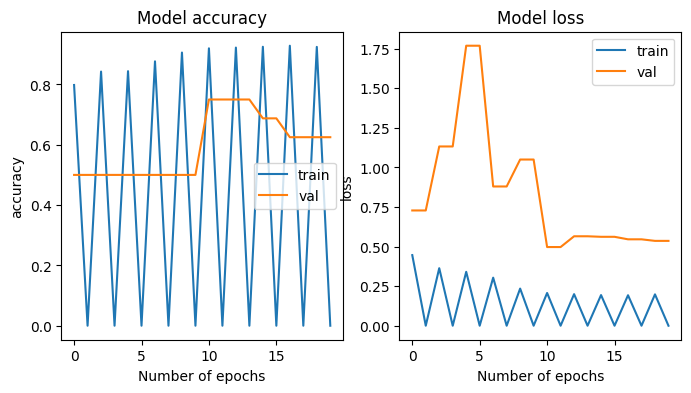

In [20]:
fig, ax = plt.subplots(1, 2, figsize = (8, 4))
ax = ax.ravel()

for i, metric in enumerate(['accuracy', 'loss']):
    ax[i].plot(model_training.history[metric])
    ax[i].plot(model_training.history['val_' + metric])
    ax[i].set_title('Model {}'.format(metric))
    ax[i].set_xlabel('Number of epochs')
    ax[i].set_ylabel(metric)
    ax[i].legend(['train', 'val'])

20/20 ━━━━━━━━━━━━━━━━━━━━ 4s 149ms/step
Test Metrics:
Accuracy: 89.1025641025641%
Precision: 91.07142857142857%
Recall: 91.53846153846153%
F1-score: 91.30434782608695
20/20 ━━━━━━━━━━━━━━━━━━━━ 2s 85ms/step
                     precision    recall  f1-score   support

   Normal (Class 0)       0.86      0.85      0.85       234
Pnuemonia (Class 1)       0.91      0.92      0.91       390

           accuracy                           0.89       624
          macro avg       0.88      0.88      0.88       624
       weighted avg       0.89      0.89      0.89       624



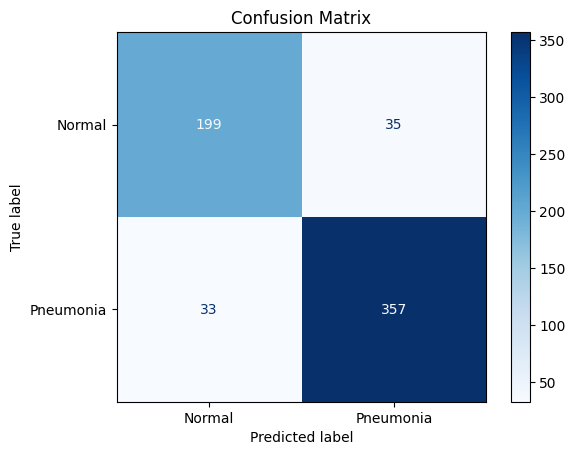

In [21]:
predictions = model.predict(test_data)
accuracy = accuracy_score(test_labels, np.round(predictions))*100
cm = confusion_matrix(test_labels, np.round(predictions))

cmd = ConfusionMatrixDisplay(cm, display_labels=['Normal', 'Pneumonia'])
cmd.plot(cmap = plt.cm.Blues)
plt.title('Confusion Matrix')

tn, fp, fn, tp = cm.ravel()
print('Test Metrics:')
precision = tp / (tp + fp) * 100
recall = tp / (tp + fn) * 100
print('Accuracy: {}%'.format(accuracy))
print('Precision: {}%'.format(precision))
print('Recall: {}%'.format(recall))
print('F1-score: {}'.format(2*precision*recall/(precision+recall)))

from sklearn.metrics import classification_report

predictions = np.round(model.predict(test_data))
print(classification_report(test_labels, predictions, target_names = ['Normal (Class 0)','Pnuemonia (Class 1)']))



1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step


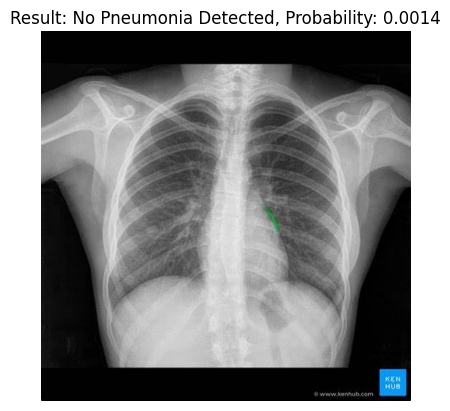

In [41]:

import cv2
import numpy as np
import matplotlib.pyplot as plt

# Read the image
def preprocess_image(image_path, img_size):
    img = cv2.imread(image_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format
    img = cv2.resize(img, (img_size, img_size))  # Resize to model input size
    img = img.astype('float32') / 255  # Normalize pixel values
    return img

def predict_pneumonia(image_path, model):
    img_size = model.input_shape[1]  # Get input image size expected by the model
    preprocessed_img = preprocess_image(image_path, img_size)
    preprocessed_img = np.expand_dims(preprocessed_img, axis=0)  # Add batch dimension
    prediction = model.predict(preprocessed_img)
    return prediction[0][0]  # Probability score

def classify_pneumonia(image_path, model, threshold=0.5):
    prediction = predict_pneumonia(image_path, model)
    if prediction >= threshold:
        return "Pneumonia Detected", prediction
    else:
        return "No Pneumonia Detected", prediction

image_path = r"C:\Users\HP\OneDrive\Pictures\Screenshots\normal.jpeg"
threshold = 0.5  # Adjust threshold as needed
result, prediction = classify_pneumonia(image_path, model, threshold)

# Display the image
img = cv2.imread(image_path)
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB format

plt.imshow(img)
plt.title(f"Result: {result}, Probability: {prediction:.4f}")
plt.axis('off')
plt.show()